In [2]:
import os
from fnmatch import fnmatch
import pandas as pd
import re
import tqdm
import plotnine as p9
import patchworklib as pw
import numpy as np

<Figure size 72x72 with 0 Axes>

In [3]:
def dict_from_path(path: str):
    params_name_pattern = "([a-zA-Z]*)-"
    param_names = [path[m.start():m.end()-1] for m in re.finditer(params_name_pattern, path)]
    dict = {}
    for param in param_names:
        dict[param] = 0
    return dict

In [4]:
def construct_regex_string(path: str, names: dict):
    res: str = ""
    last_key = list(names.keys())[-1]
    for key in list(names.keys()):
        res = res + key + "-([0-9.]*)"
        if key != last_key:
            res = res + '_'
    return res

In [5]:
def extract_parms(filepath: str):
    param_st = filepath.split('/')[-2]
    params = dict_from_path(param_st)
    regex_str = construct_regex_string(param_st, params)
    result = re.search(regex_str, param_st)
    keys = list(params.keys())
    for x, key in enumerate(keys):
        params[key] = float(result.group(x+1))
    return params

In [67]:
root = os.path.join(os.getcwd(),'output_6_9')
pattern = "logger_6_Ve.csv"
file_paths = []
dfsV = []

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            file_path = os.path.join(path, name)
            file_paths.append(file_path)
            df = pd.read_csv(file_path, sep='\t')
            params = extract_parms(file_path)
            for key in list(params.keys()):
                df[key] = params[key]
            dfsV.append(df)

In [68]:
pd.concat(dfsV)

,10,0,1,2,3,4,5,6,7,8,9,DV,bcf,pi,cv
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.001,0.1,0.05
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.001,0.1,0.05
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.001,0.1,0.05
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.001,0.1,0.05
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.001,0.1,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,5,0.166867,0.183278,0.217082,0.269927,0.344957,0.440634,0.546093,0.640480,0.712863,0.758604,0.8,0.001,0.5,0.05
556,6,0.150354,0.163462,0.190068,0.230632,0.284949,0.352056,0.426192,0.499626,0.568516,0.615513,0.8,0.001,0.5,0.05
557,7,0.136392,0.146858,0.167814,0.199104,0.239916,0.288191,0.340486,0.393219,0.441843,0.475961,0.8,0.001,0.5,0.05
558,8,0.126343,0.135014,0.152192,0.177417,0.209672,0.247075,0.286702,0.324740,0.357957,0.378896,0.8,0.001,0.5,0.05


In [50]:
simV = pd.concat(dfsV)
simV = simV[simV["10"] != 10]
simV['time'] = np.tile(np.repeat(range(0,51),10),int(len(simV.index)/510))
simV['sum_V_x'] = simV.iloc[:, 1:11].sum(axis=1)
simV = simV.drop(columns=[str(x) for x in range(0,11)])
simV = simV.groupby(list(simV.columns[:-1])).agg({'sum_V_x': 'sum'}).reset_index()
simV['cv_cat'] = simV['cv'].astype("category")
simV

,DV,bcf,pi,cv,time,sum_V_x,cv_cat
0,0.0,0.001,0.01,0.05,0,0.0,0.05
1,0.0,0.001,0.01,0.05,1,0.0,0.05
2,0.0,0.001,0.01,0.05,2,0.0,0.05
3,0.0,0.001,0.01,0.05,3,0.0,0.05
4,0.0,0.001,0.01,0.05,4,0.0,0.05
...,...,...,...,...,...,...,...
42835,999.0,1.000,1.00,1.00,46,87.0,1.00
42836,999.0,1.000,1.00,1.00,47,87.0,1.00
42837,999.0,1.000,1.00,1.00,48,87.0,1.00
42838,999.0,1.000,1.00,1.00,49,87.0,1.00


In [77]:
I = np.expand_dims(range(0,51), axis=1)

In [75]:
timesteps=50
def calculate_V(df: pd.DataFrame):
    df = df[df["10"]!=10]
    morpheus_ts = np.repeat(range(0,timesteps+1),10)
    df["time"] = np.tile(morpheus_ts,int(len(df.index)/morpheus_ts.shape[0]))
    df['sum_V'] = df.iloc[:, 1:11].sum(axis=1)
    df = df.drop(columns=[str(x) for x in range(0,11)])
    df = df.groupby(list(df.columns[:-1])).agg({'sum_V': 'sum'}).reset_index()
    return df

In [76]:
path = '/home/l/projects/Morpheus/Modelle/cell_free_50/output_6_9/DV-1_bcf-0.001_pi-0.1_cv-0.5/logger_6_Ve.csv'
df = pd.read_csv(path, sep='\t')
df_sum = calculate_V(df)
df_sum.shape

(51, 2)

In [81]:
np.append(I,np.expand_dims(df_sum['sum_V'],axis=1),axis=1)

array([[ 0.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 2.        ,  0.        ],
       [ 3.        ,  0.        ],
       [ 4.        ,  0.        ],
       [ 5.        ,  0.        ],
       [ 6.        ,  0.        ],
       [ 7.        ,  0.        ],
       [ 8.        ,  0.        ],
       [ 9.        ,  0.        ],
       [10.        ,  0.        ],
       [11.        ,  0.        ],
       [12.        ,  0.07864583],
       [13.        ,  0.12636583],
       [14.        ,  0.15532093],
       [15.        ,  0.17289005],
       [16.        ,  0.18355047],
       [17.        ,  0.19001891],
       [18.        ,  0.19394376],
       [19.        ,  0.19632525],
       [20.        ,  0.19777027],
       [21.        ,  0.19864706],
       [22.        ,  0.19917908],
       [23.        ,  0.19950189],
       [24.        ,  0.19969776],
       [25.        ,  0.19981661],
       [26.        ,  0.19988872],
       [27.        ,  0.19993248],
       [28.        ,

In [66]:
simV[simV["DV"]==1.0]

,DV,bcf,pi,cv,time,sum_V_x,cv_cat
30600,1.0,0.001,0.01,0.05,0,0.0,0.05
30601,1.0,0.001,0.01,0.05,1,0.0,0.05
30602,1.0,0.001,0.01,0.05,2,0.0,0.05
30603,1.0,0.001,0.01,0.05,3,0.0,0.05
30604,1.0,0.001,0.01,0.05,4,0.0,0.05
...,...,...,...,...,...,...,...
36715,1.0,1.000,1.00,1.00,46,181.0,1.00
36716,1.0,1.000,1.00,1.00,47,181.0,1.00
36717,1.0,1.000,1.00,1.00,48,181.0,1.00
36718,1.0,1.000,1.00,1.00,49,181.0,1.00


In [65]:
simV['DV'].unique()

array([0.00e+00, 2.00e-01, 4.00e-01, 6.00e-01, 8.00e-01, 1.00e+00,
       9.99e+02])

In [53]:
plots_V = []
for dv in simV['DV'].unique():
    plot = (p9.ggplot(simV[simV['DV'] == dv], p9.aes(x='time', color='cv_cat'))
            + p9.geom_line(p9.aes(y='sum_V_x'))
            + p9.facet_grid('bcf ~ pi', labeller = 'label_both')
            + p9.labs(title="DV: " + str(dv))
            )
    plots_V.append(pw.load_ggplot(plot))
print("nr of plots: " + str(len(simV['DV'].unique())))

nr of plots: 7


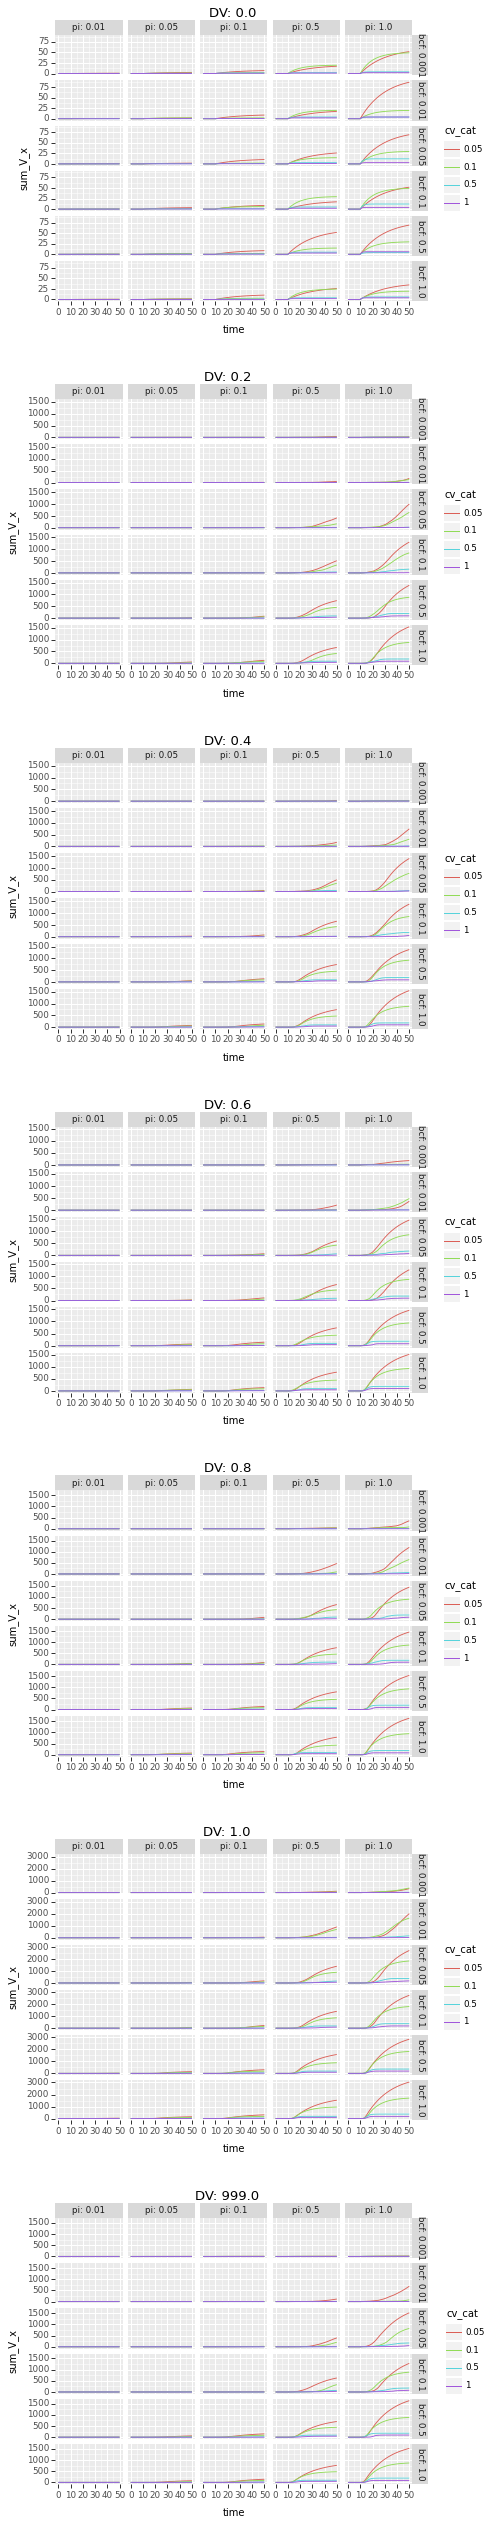

In [54]:
figure = plots_V[0]/plots_V[1]/plots_V[2]/plots_V[3]/plots_V[4]/plots_V[5]/plots_V[6]
figure.savefig()

In [69]:
root = os.path.join(os.getcwd(),'output_6_9')
pattern = "logger_2.csv"
file_paths = []
dfs = []

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            file_path = os.path.join(path, name)
            file_paths.append(file_path)
            df = pd.read_csv(file_path, sep='\t')
            params = extract_parms(file_path)
            for key in list(params.keys()):
                df[key] = params[key]
            dfs.append(df)

In [70]:
pd.concat(dfs)

,time,celltype.target.size,celltype.infected.size,DV,bcf,pi,cv
0,0,49,1,0.2,0.001,0.1,0.05
1,1,49,1,0.2,0.001,0.1,0.05
2,2,49,1,0.2,0.001,0.1,0.05
3,3,49,1,0.2,0.001,0.1,0.05
4,4,49,1,0.2,0.001,0.1,0.05
...,...,...,...,...,...,...,...
46,46,47,3,0.8,0.001,0.5,0.05
47,47,47,3,0.8,0.001,0.5,0.05
48,48,47,3,0.8,0.001,0.5,0.05
49,49,47,3,0.8,0.001,0.5,0.05


In [62]:
file_paths

['/home/l/projects/Morpheus/Modelle/cell_free_50/output_6_9/DV-0.2_bcf-0.001_pi-0.1_cv-0.05/logger_2.csv',
 '/home/l/projects/Morpheus/Modelle/cell_free_50/output_6_9/DV-0_bcf-0.5_pi-0.5_cv-0.1/logger_2.csv',
 '/home/l/projects/Morpheus/Modelle/cell_free_50/output_6_9/DV-1_bcf-0.001_pi-0.1_cv-0.5/logger_2.csv',
 '/home/l/projects/Morpheus/Modelle/cell_free_50/output_6_9/DV-0.4_bcf-1_pi-0.5_cv-0.05/logger_2.csv',
 '/home/l/projects/Morpheus/Modelle/cell_free_50/output_6_9/DV-0.0_bcf-1_pi-0.05_cv-0.5/logger_2.csv',
 '/home/l/projects/Morpheus/Modelle/cell_free_50/output_6_9/DV-1.0_bcf-0.5_pi-1_cv-0.5/logger_2.csv',
 '/home/l/projects/Morpheus/Modelle/cell_free_50/output_6_9/DV-999_bcf-0.1_pi-0.05_cv-0.5/logger_2.csv',
 '/home/l/projects/Morpheus/Modelle/cell_free_50/output_6_9/DV-0.8_bcf-0.5_pi-0.05_cv-0.1/logger_2.csv',
 '/home/l/projects/Morpheus/Modelle/cell_free_50/output_6_9/DV-0.4_bcf-0.5_pi-0.5_cv-0.5/logger_2.csv',
 '/home/l/projects/Morpheus/Modelle/cell_free_50/output_6_9/DV-1.

In [58]:
sim = pd.concat(dfs)
sim = sim[sim['time'] >= 10]
sim['cv_cat'] = sim['cv'].astype("category")

In [59]:
sim.describe()

,time,celltype.target.size,celltype.infected.size,DV,bcf,pi,cv
count,44280.000000,44280.000000,44280.000000,44280.000000,44280.000000,44280.000000,44280.000000
mean,30.000000,38.814995,11.185005,111.444444,0.276833,0.332000,0.412500
std,11.832293,17.919680,17.919680,313.802032,0.365787,0.377226,0.381408
min,10.000000,0.000000,1.000000,0.000000,0.001000,0.010000,0.050000
25%,20.000000,40.000000,1.000000,0.200000,0.010000,0.050000,0.087500
50%,30.000000,49.000000,1.000000,0.600000,0.075000,0.100000,0.300000
75%,40.000000,49.000000,10.000000,1.000000,0.500000,0.500000,0.625000
max,50.000000,49.000000,50.000000,999.000000,1.000000,1.000000,1.000000


In [60]:
sim[sim['DV'] == 1.0]

,time,celltype.target.size,celltype.infected.size,DV,bcf,pi,cv,cv_cat
10,10,49,1,1.0,0.001,0.1,0.50,0.50
11,11,49,1,1.0,0.001,0.1,0.50,0.50
12,12,49,1,1.0,0.001,0.1,0.50,0.50
13,13,49,1,1.0,0.001,0.1,0.50,0.50
14,14,49,1,1.0,0.001,0.1,0.50,0.50
...,...,...,...,...,...,...,...,...
46,46,0,50,1.0,0.050,0.5,0.05,0.05
47,47,0,50,1.0,0.050,0.5,0.05,0.05
48,48,0,50,1.0,0.050,0.5,0.05,0.05
49,49,0,50,1.0,0.050,0.5,0.05,0.05


In [41]:
plots = []
for dv in sim['DV'].unique():
    plot = (p9.ggplot(sim[sim['DV'] == dv], p9.aes(x='time', color='cv_cat'))
            + p9.geom_line(p9.aes(y='celltype.infected.size'))
            + p9.facet_grid('bcf ~ pi', labeller = 'label_both')
            + p9.labs(title="DV: " + str(dv))
            )
    plots.append(pw.load_ggplot(plot))
print("nr of plots: " + str(len(sim['DV'].unique())))

nr of plots: 7


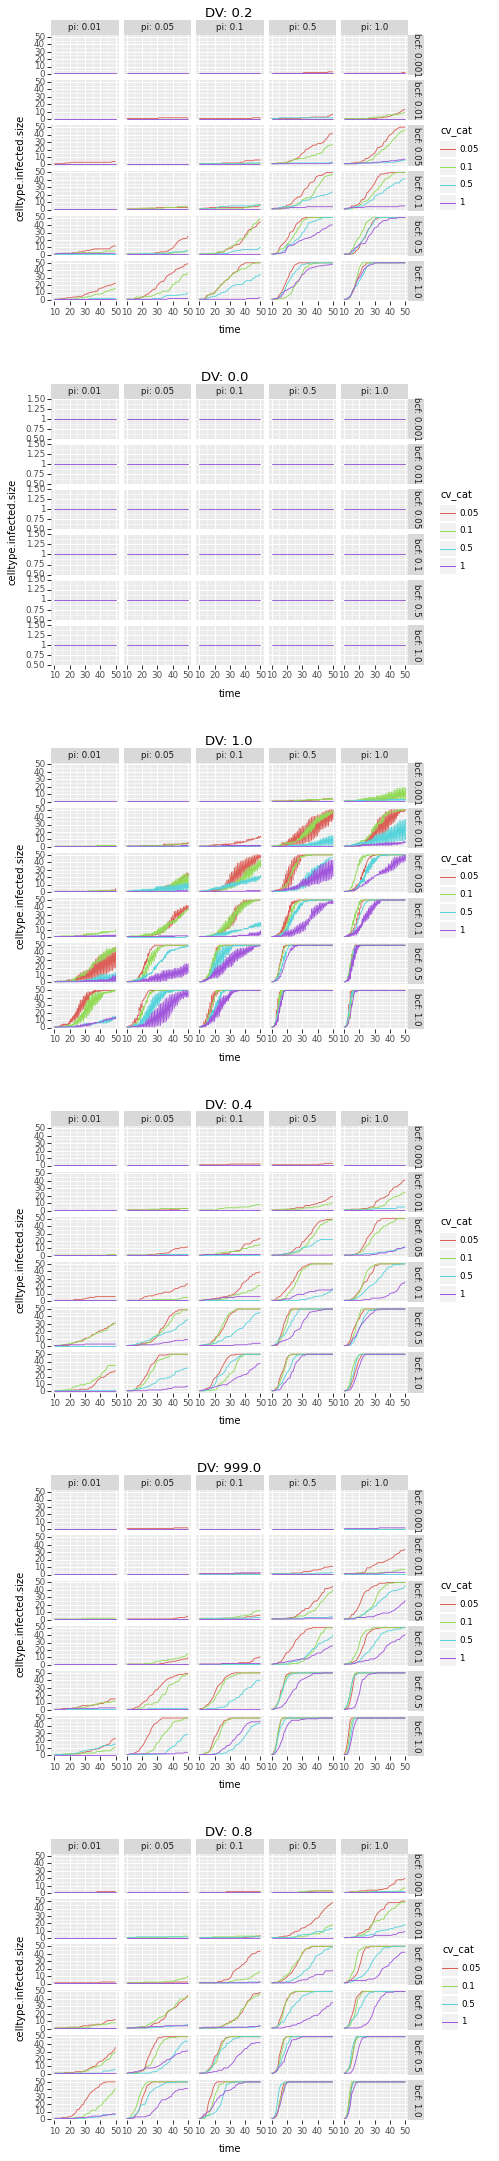

In [43]:
figure = plots[0]/plots[1]/plots[2]/plots[3]/plots[4]/plots[5]
figure.savefig()

In [26]:
sim[sim['DV'] == 0.2]

,time,celltype.target.size,celltype.infected.size,DV,bcf,rhoi,cv
0,0,49,1,0.2,0.10,0.50,1.00
1,1,49,1,0.2,0.10,0.50,1.00
2,2,49,1,0.2,0.10,0.50,1.00
3,3,49,1,0.2,0.10,0.50,1.00
4,4,49,1,0.2,0.10,0.50,1.00
...,...,...,...,...,...,...,...
46,46,48,2,0.2,0.05,0.01,0.05
47,47,48,2,0.2,0.05,0.01,0.05
48,48,48,2,0.2,0.05,0.01,0.05
49,49,48,2,0.2,0.05,0.01,0.05


In [36]:
sim.query('DV==0.2 & cv==0.1 & bcf==0.1 & rhoi==0.1')
simDV2 = sim[sim['DV'] == 0.2]
simDV2['cv_cat'] = simDV2['cv'].astype("category")

,time,celltype.target.size,celltype.infected.size,DV,bcf,rhoi,cv
0,0,49,1,0.2,0.1,0.1,0.1
1,1,49,1,0.2,0.1,0.1,0.1
2,2,49,1,0.2,0.1,0.1,0.1
3,3,49,1,0.2,0.1,0.1,0.1
4,4,49,1,0.2,0.1,0.1,0.1
5,5,49,1,0.2,0.1,0.1,0.1
6,6,49,1,0.2,0.1,0.1,0.1
7,7,49,1,0.2,0.1,0.1,0.1
8,8,49,1,0.2,0.1,0.1,0.1
9,9,49,1,0.2,0.1,0.1,0.1
